### Model for quantifying performance of the trained model

In [1]:
import contextlib
import glob
import io
import json
import os
import random
import time

from fvcore.common.file_io import PathManager
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import torch 
from torchvision.ops import nms

import detectron2
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.structures import BoxMode

# local .json file with local path info
geladas_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

from detectron2_classes.DetectionDatasetMapper import DetectionDatasetMapper
from detectron2_classes.PrecisionRecallEvaluator import PrecisionRecallEvaluator
from detectron2_classes.GroundtruthVisualizer import GroundtruthVisualizer

In [2]:
detectron2.__version__

'0.2.1'

In [ ]:
# Name of model to evaluate
model_name = "males-random-plateau-LRscheduler-cropped-color-aug-new-dataloader_maxiter-2000_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"

In [3]:
base_folder = local_paths["annotations_folder"]
images_folder = os.path.join(base_folder, "annotated_images")

In [4]:
models_folder = os.path.join(os.getcwd(), "output")
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')

In [5]:
cfg = get_cfg()
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(cfg.OUTPUT_DIR, "best-model-config-iter-*.pth"))
)[-1]
print(weights_path)
cfg.MODEL.WEIGHTS = os.path.join(weights_path)

./output/males-random-plateau-LRscheduler-cropped-color-aug-new-dataloader_maxiter-2000_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/best-model-config-iter-1599-loss-0.8413200231946327.pth


In [6]:
print(cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
print(cfg.MODEL.ROI_HEADS.NUM_CLASSES)

0.05
3


In [7]:
# Annotated datasets to use for performance quantification
train_json = os.path.join(base_folder, 'train_males.json') 
val_json = os.path.join(base_folder, 'coco_males_export-2022-01-05T15_54_11.401Z-val.json')

test_json = os.path.join(base_folder, 'coco_males_export-2022-01-05T15_54_50.050Z-test.json')


register_coco_instances("train", {}, train_json, images_folder)
register_coco_instances("val", {}, val_json, images_folder)
register_coco_instances("test", {}, test_json, images_folder)

train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")
test_dicts = DatasetCatalog.get("test")

num_train_images = len(train_dicts)
num_val_images = len(val_dicts)
num_test_images = len(test_dicts)
print(f"{num_train_images} training images \n",
      f"{num_val_images} validation images \n",
      f"{num_test_images} test images"
     )

69 training images 
 22 validation images 
 16 test images 
 33 square train images


In [8]:
train_metadata = MetadataCatalog.get("train")
train_metadata.get("thing_classes")

['adult_male', 'gelada', 'human']

In [45]:
# Name of one of the datasets specified above to actually use
dataset_name = "test"
mapper = DetectionDatasetMapper(cfg, is_train=False, calc_val_loss=False)
loader = build_detection_test_loader(cfg, dataset_name, mapper)

### Visualize predictions on two images

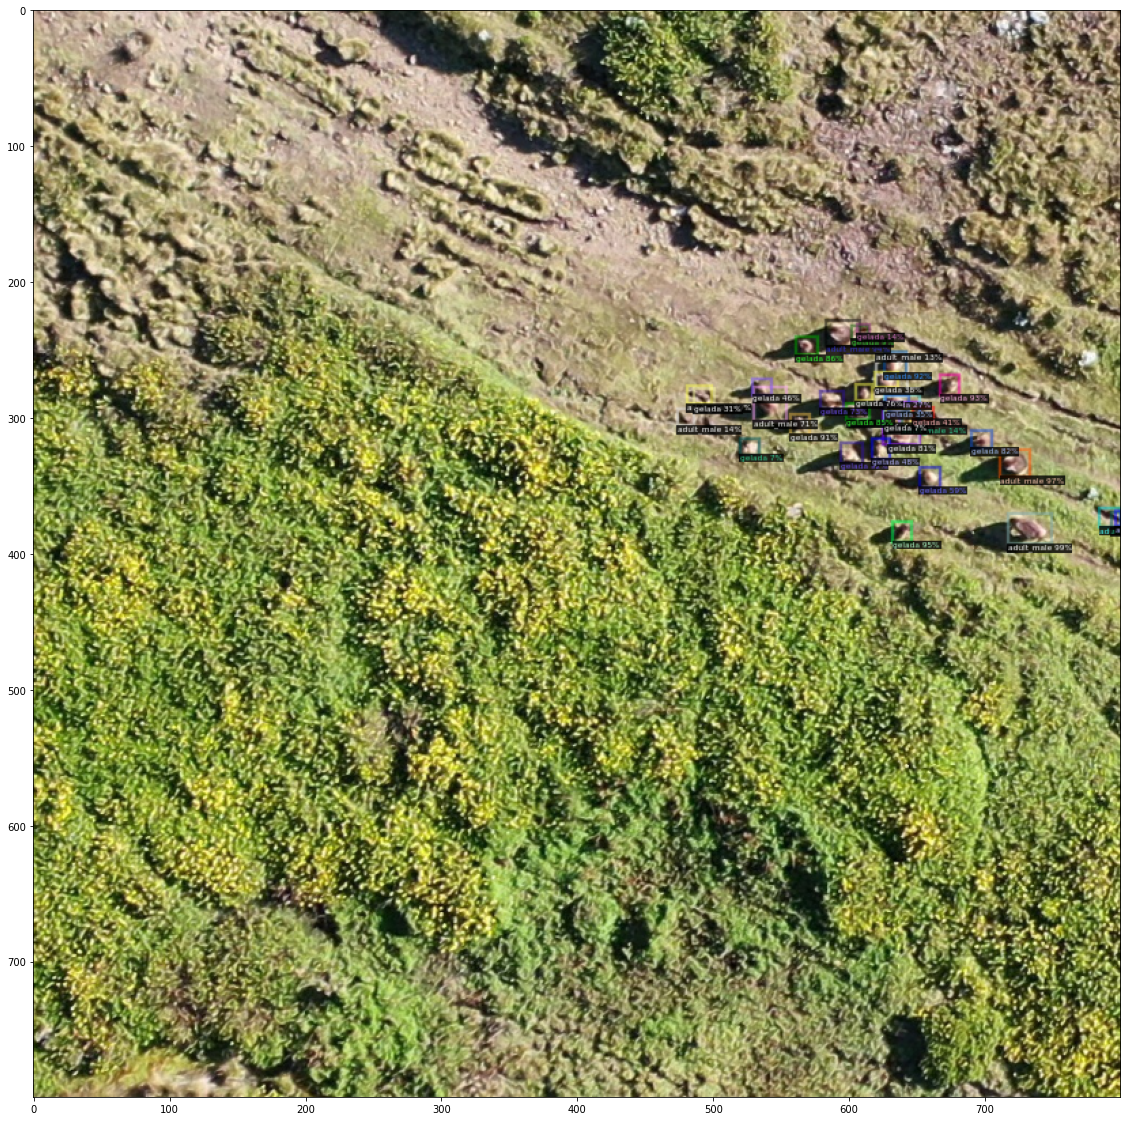

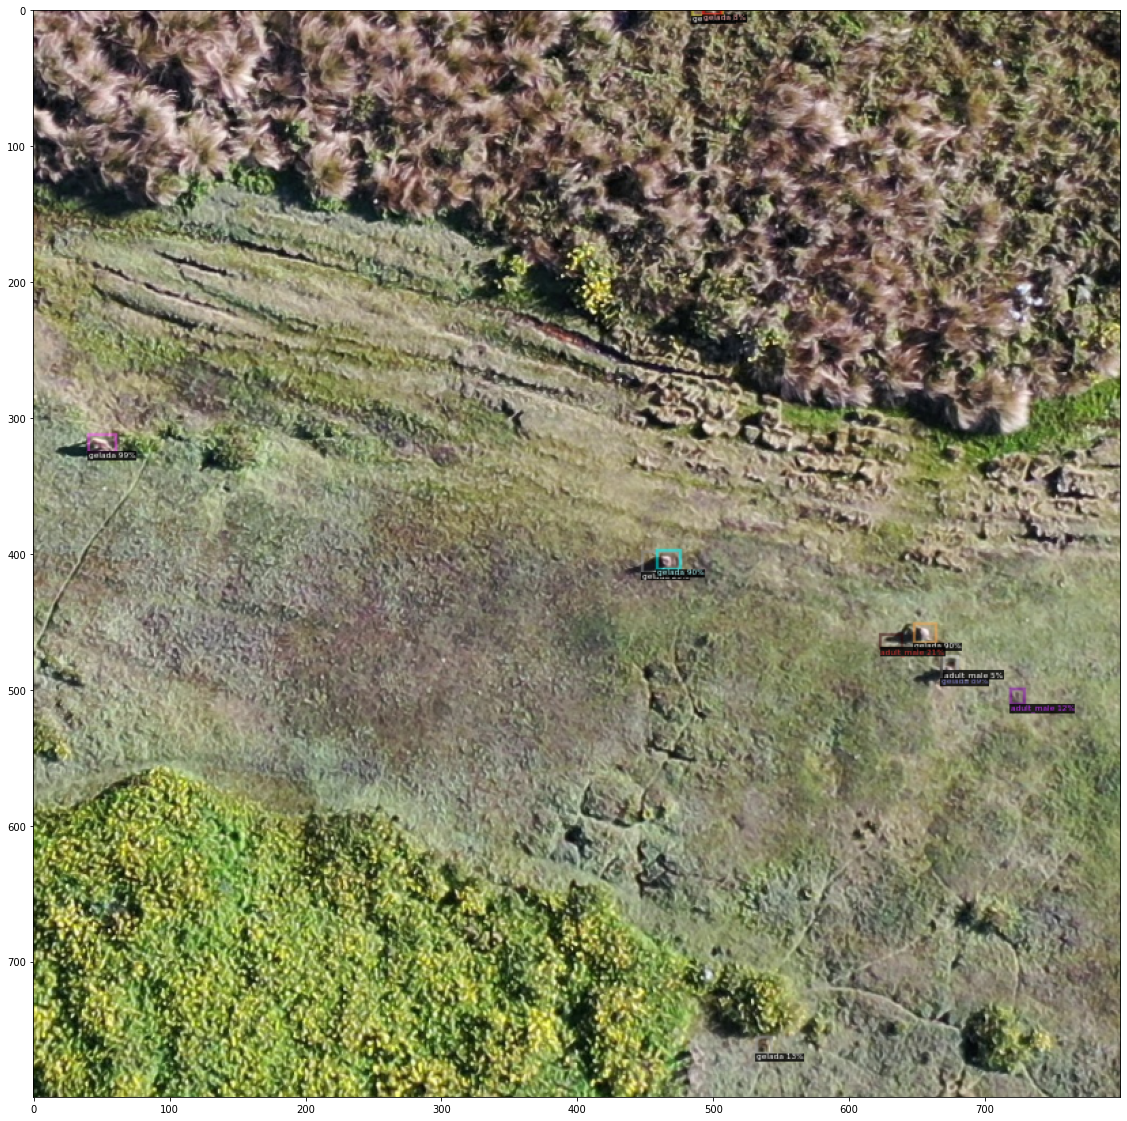

In [48]:
cfg.DATASETS.TEST = (dataset_name, )
predictor = DefaultPredictor(cfg)

if dataset_name == 'train':
    dataset_dict = train_dicts
elif dataset_name == 'val':
    dataset_dict = val_dicts
elif dataset_name == 'test':
    dataset_dict = test_dicts
elif dataset_name == 'train_square':
    dataset_dict = square_train_dicts

for d in random.sample(dataset_dict, 2):
# for d in dataset_dict:
    im = utils.read_image(
        d["file_name"], format=cfg.INPUT.FORMAT
    )
    outputs = predictor(im)
    
    instances = outputs["instances"].to("cpu")
    
    valid_ind = nms(instances.pred_boxes.tensor, instances.scores, iou_threshold=.5)
    instances.pred_boxes.tensor = instances.pred_boxes.tensor[valid_ind]
    instances.scores = instances.scores[valid_ind]
    
    v = GroundtruthVisualizer(im[:, :, ::],
                   metadata=train_metadata,
                   scale=0.8,
                   
    )
    v = v.draw_instance_predictions(instances)
    plt.figure(figsize=(20,20))
    plt.imshow(v.get_image()[:, :, ::-1])

In [49]:
# Check model performance on the specified set
evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False, min_iou=.2)
evaluator.reset()

cfg.DATASETS.TEST = (dataset_name, )

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')
        outputs = model(batch)
        
        instances = outputs[0]["instances"]
        # Postprocessing
        valid_ind = nms(instances.pred_boxes.tensor, instances.scores, iou_threshold=.5)
        instances.pred_boxes.tensor = instances.pred_boxes.tensor[valid_ind]
        instances.scores = instances.scores[valid_ind]
        instances.pred_classes = instances.pred_classes[valid_ind]
        outputs[0]["instances"] = instances
        
        evaluator.process(batch, outputs)             

coco_result = evaluator.evaluate()

custom
Using custom min iou: 0.2
processed batch 0
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Using min iou threshold of 0.2.
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.20:0.95 | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.20:0.95 | area= small | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.20:0.95 | area=medium | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.20:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.20:0.95 | area=   all | maxDets=  1 ] = 0.370
 Average Recall     (AR) @[ IoU=0.20:0.95 | area=   all | maxDets= 10 ] = 

In [50]:
coco_result['bbox']['res']

{'AP': 63.17638296857114,
 'AP50': 87.520393586154,
 'AP75': 48.22749996362371,
 'APs': 61.46838037997293,
 'APm': 68.52310231023102,
 'APl': nan,
 'AP-adult_male': 58.009210578012684,
 'AP-gelada': 60.95269410327828,
 'AP-human': 70.56724422442244}

Max detections: 100


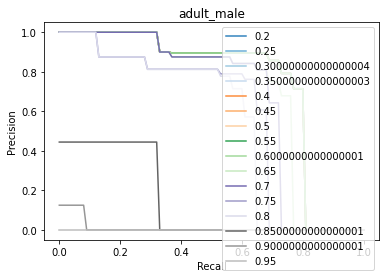

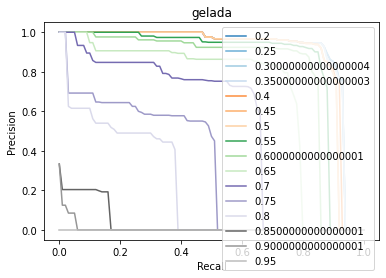

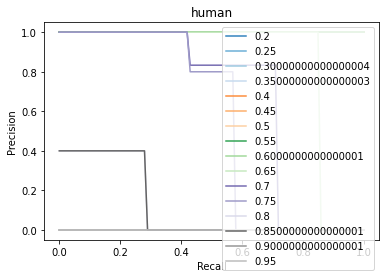

In [51]:
# See https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
# for details about the output

params = coco_result['bbox']['params']
precision = coco_result['bbox']['precision']

max_dets_ind = 2
print(f"Max detections: {params.maxDets[max_dets_ind]}")

area_rng_ind = 0 # 0 corresponds to all detection sizes

cm = plt.cm.tab20c

for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    plt.figure()
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, 
                 precision[iou_ind, :, obj_class, area_rng_ind, max_dets_ind], 
                 label=iou_thrsh, c=cm(iou_ind/len(params.iouThrs)))
    plt.legend()
    plt.title(train_metadata.get("thing_classes")[obj_class])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

In [52]:
# default iou thresh values are 
# [0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]
iou_thresh_ind = 8
print(f"Using an iou threshold of {params.iouThrs[iou_thresh_ind]}")

score_thresh = .7
print(f"Using score threshold of {score_thresh}")

max_dets_ind = 2 

area_rng_ind = 0 # 0 corresponds to all detection sizes
print(f"Using area size range {params.areaRng[area_rng_ind]}")

print("")

scores = coco_result['bbox']['scores']

for obj_class, obj_name in enumerate(train_metadata.get("thing_classes")):  
    above_thresh = np.argwhere(
        scores[iou_thresh_ind, :, obj_class, area_rng_ind, max_dets_ind] >= score_thresh)
    if len(above_thresh) == 0:
        print(f"{obj_name:8}: recall: {np.nan:1.2f}, precision: {np.nan:1.3f}")
        continue
    max_ind = np.max(above_thresh)
    print(f"{obj_name:8}: recall: {params.recThrs[max_ind]:1.2f}, "
          f"precision: {precision[iou_thresh_ind, max_ind, obj_class, area_rng_ind, max_dets_ind]:1.3f}")

Using an iou threshold of 0.6000000000000001
Using score threshold of 0.7
Using area size range [0, 10000000000.0]

adult_male: recall: 0.72, precision: 0.857
gelada  : recall: 0.81, precision: 0.890
human   : recall: 1.00, precision: 1.000


### Visualize detections if you want

In [16]:
dataset_metadata = MetadataCatalog.get(dataset_name)
json_file = PathManager.get_local_path(dataset_metadata.json_file)
with contextlib.redirect_stdout(io.StringIO()):
    coco_api = COCO(json_file)

In [17]:
coco_api.createIndex()

creating index...
index created!


In [18]:
# Check training

evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False)
# evaluator = COCOEvaluator(dataset_name, cfg, distributed=False)
evaluator.reset()

show_ims = False
show_gts = False

cfg.DATASETS.TEST = (dataset_name, )
# predictor = DefaultPredictor(cfg)

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

all_outputs = []

t = time.time()
with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')

        outputs = model(batch)
        

        all_outputs.extend(outputs)
    
        evaluator.process(batch, outputs)
        if show_ims:   
            for ind, output in enumerate(outputs):
                im = (
                    np.transpose(batch[0]['image'].numpy(), (1, 2, 0))
                ).astype(int)
                
                im_id = batch[ind]['image_id']

                gts=coco_api.loadAnns(coco_api.getAnnIds(imgIds=[im_id]))
                anno_dict = {}
                for gt in gts:
                    gt['bbox_mode'] = BoxMode.XYWH_ABS
                anno_dict['annotations'] = gts
                
                scale = 0.8
                if show_gts:
                    v = GroundTruthVisualizer(im,
                               metadata=train_metadata,
                               scale=1.0,
                    )
                    v_gt = v.draw_dataset_dict(anno_dict)
                    im = v_gt.get_image()
                    plt.figure(figsize=(20, 20))
                    plt.imshow(v_gt.get_image()[:, :, ::-1])
                v = Visualizer(im,
                               metadata=train_metadata,
                               scale=scale,
                )
                v_im = v.draw_instance_predictions(output["instances"].to("cpu"))
                
                plt.figure(figsize=(20, 20))
                plt.imshow(v_im.get_image()[:, :, ::-1])
                
                
        if batch_num >= 1000:
            print(f'batch {batch_num}')
            break
total_time = time.time() - t
print(f"fps: {batch_num/total_time}, total_time {total_time}, num_frames {batch_num}")

coco_result = evaluator.evaluate()

processed batch 0
fps: 2.3737127536818017, total_time 13.480990886688232, num_frames 32
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.03 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10